# Lesson 2: Document Chunking Strategies

**Objective**: Learn how to effectively segment documents for better retrieval performance.

**Topics**:

- Chunking techniques: token-level, sentence-level, semantic-level
- Balancing context preservation with retrieval precision
- Small2Big and sliding window techniques

**Practical Task**: Implement chunking strategies on a sample dataset.

**Resources**:
- The five levels of chunking
- A guide to chunking
- [Visualizing chunking](https://chunkviz.up.railway.app/)
- [Full stack retrieval](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/a4570f3c4883eb9b835b0ee18990e62298f518ef/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb)

## The five levels of chunking

### Level 1 - Character splitting

Es el metodo de *chunking* mas simple y basica, es el proceso por el cual solo dividimos el texto en *chunks* de tamaño *N* caracteres sin importar su contenido o forma.

Este metodo no es recomendado para ninguna aplicación, pero puede ser un buen punto de partida para entender los fundamentos.

- Pros: facil y rapido
- Cons: Muy rigido y no toma en cuenta la estructura del texto

Conceptos a saber:

- Chunk size: El número de caracteres que define el largo del chunk.
- Chunk overlap: La cantidad de caracteres que tiene que sobrelaparse en chunks secuenciales. Esto es para evitar cortar el contexto en multiples partes, perdiendo el significado semantico de algún pasaje. Esto creara duplicados entre los chunks.

#### Ejemplo manual

In [5]:
text = "This is the text I would like to chunk up. It is the example text for this exercise"

# Create a list that will hold your chunks
chunks = []

chunk_size = 35 # Characters

# Run through the a range with the length of your text and iterate every chunk_size you want
for i in range(0, len(text), chunk_size):
    chunk = text[i:i + chunk_size]
    chunks.append(chunk)
chunks

['This is the text I would like to ch',
 'unk up. It is the example text for ',
 'this exercise']

#### Usando el framework LangChain

- Normalmente para aplicaciones de RAG no trabajamos con strings, trabajamos con onjetos del tipo Document. Estos objetos contienen el texto que queremos pero ademas contienen metadata adicional que permite hacer filtros mas complejos. Eso lo veremos mas adelante.

In [2]:
from langchain.text_splitter import CharacterTextSplitter

Cargamos el text splitter de LangChain, necesitamos especificar el chunk overlap y el separator, si no los entregamos tendremos resultados no deseados.

In [7]:
# No overlap
text_splitter = CharacterTextSplitter(chunk_size = 35, chunk_overlap=0, separator='', strip_whitespace=True)

In [8]:
text_splitter.create_documents([text])

[Document(page_content='This is the text I would like to ch'),
 Document(page_content='unk up. It is the example text for'),
 Document(page_content='this exercise')]

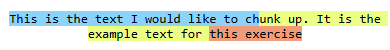

Si observamos logramos el mismo resultado que con la opción manual, pero ahora tenemos las estructuras de datos que son compatibles con el resto del framework. Ademas, pudimos hacer un poco de limpieza del string, en el caso del espacio en blanco de la segunda linea, utilizando strip_whitespace=True.

In [9]:
# With overlap
text_splitter = CharacterTextSplitter(chunk_size = 35, chunk_overlap=4, separator='')
text_splitter.create_documents([text])

[Document(page_content='This is the text I would like to ch'),
 Document(page_content='o chunk up. It is the example text'),
 Document(page_content='ext for this exercise')]

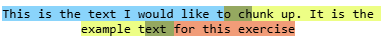

Si nos fijamos tenemos los mismos chunks, pero entre el chunk 1 y 2 y el chunk 2 y 3 algunos caracteres se repiten.

### Level 2: Recursive Character Text Splitting

Ahora subamos la complejidad.

Uno de los contras de la aproximación anterior es que no tomamos en cuenta la estructura del documentos. Simplemente contamos caracteres y cortamos. 

En el caso del Recursive Character Text Splitter nos ayuda a considerar al menos la estructura del texto, vamos a especificar una serie de separadores que se usaran para separar nuestro docuemento.

Estos son los separadores disponibles:

- "\n\n" - Double new line, or most commonly paragraph breaks
- "\n" - New lines
- " " - Spaces
- "" - Characters

Este es la solución mas efectiva para comenzar a prototipar una aplicación rapidamente. Si no sabemos cual utilizar, esta es la primera opción para probar.

In [11]:
# Imports
from langchain.text_splitter import RecursiveCharacterTextSplitter

Vamos a probar un texto mas largo

In [12]:
text = """
One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear.

Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor's, you don't get half as many customers. You get no customers, and you go out of business.

It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, the rich get richer. [1]
"""

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 65, chunk_overlap=0)

In [14]:
text_splitter.create_documents([text])

[Document(page_content="One of the most important things I didn't understand about the"),
 Document(page_content='world when I was a child is the degree to which the returns for'),
 Document(page_content='performance are superlinear.'),
 Document(page_content='Teachers and coaches implicitly told us the returns were linear.'),
 Document(page_content='"You get out," I heard a thousand times, "what you put in." They'),
 Document(page_content='meant well, but this is rarely true. If your product is only'),
 Document(page_content="half as good as your competitor's, you don't get half as many"),
 Document(page_content='customers. You get no customers, and you go out of business.'),
 Document(page_content="It's obviously true that the returns for performance are"),
 Document(page_content='superlinear in business. Some think this is a flaw of'),
 Document(page_content='capitalism, and that if we changed the rules it would stop being'),
 Document(page_content='true. But superlinear returns for

Si nos fijamos, varios de los chunks terminana con un **"."**. Esto es porque probablemente son el fin de un parrafo y el splitter primero revisa si existe el doble salto de linea.

Una vez que los parrafos se separaron, el splitter mira el chunk size, si el demasiado grande, lo separa por el separador que sigue. Si el chunk sigue siendo muy largo, continua con todos los separadores.

In [15]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 450, chunk_overlap=0)
text_splitter.create_documents([text])

[Document(page_content="One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear."),
 Document(page_content='Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor\'s, you don\'t get half as many customers. You get no customers, and you go out of business.'),
 Document(page_content="It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, the rich get richer. [1]")]

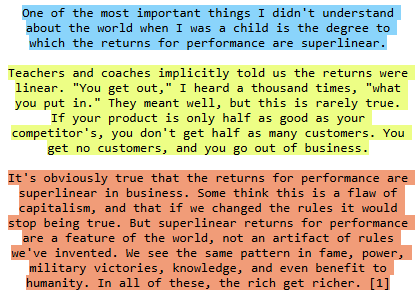



### Level 3: Document Specific Splitting

Seguimos aumentando la complejidad, ahora veamos distintos tipos de documentos distintos a un .txt. Que pasa si tenemos imagenes? es un PDF? o codigo?

Las aproximaciones anteriores no van a funcionar muy bien con este tipo de documentos.

Este nivel es todo acerca de ajustar la estrategia de **chunking** a nuestro caso de uso. Por ahora solo veremos como tratamos PDF complejos. Pero también podemos procesar otro tipo de archivos, como Markdown, Python, JS, etc.

#### PDF con tablas

Los archivos PDF con tablas son extremadamente comunes, aparecen en todo tipo de docuemntos, legales, documentos cientificos, datos financietos, etc.

Separar tablas con otros tipos de splitters no es 

In [4]:
import os
from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import elements_to_json

c:\repos\rag-course\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Level 4: Semantic Chunking

Considerando que las aproximaciones solo consideran dividir el texto en largos fijos, o definidos por limitadores. No parece extraño que ninguna de esas aproximaciones no tome en contexto el contenido de los documentos?

Existe una mejor forma.

Los embeddings representan el significado semantico de un string, Por si mismos, no son muy utiles, pero cuan se comparan con otros, es posible inferir la relación entre distintos strings.

La hipotesis entonces es que chunks semanticamente similares deberían agruparse juntos.

Find break points between sequential sentences - Next up I tried a walk method. I started at the first sentence, got the embedding, then compared it to sentence #2, then compared #2 and #3 and so on. I was looking for "break points" where embedding distance was large. If it was above a threshold, then I considered it the start of a new semantic section. I originally tried taking embeddings of every sentence, but this turned out to be too noisy. So I ended up taking groups of 3 sentences (a window), then got an embedding, then dropped the first sentence, and added the next one. This worked out a bit better.



In [1]:
with open("../data/mit.txt") as file:
    essay = file.read()

essay

'October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school. I think there will increasingly be a third option: to start your own startup. But how common will that be?\n\nI\'m sure the default will always be to get a job, but starting a startup could well become as popular as grad school. In the late 90s my professor friends used to complain that they couldn\'t get grad students, because all the undergrads were going to work for startups. I wouldn\'t be surprised if that situation returns, but with one difference: this time they\'ll be starting their own instead of going to work for other people\'s.\n\nThe most ambitious students will at this point be asking: Why wait till you graduate? Why not start a startup while you\'re in college? In fact, why go to college at all? Why not start a startup instead?\n\nA year and a half ago I gave a talk where I said that the average age of the founders of Yahoo, Go

Then I want to split the entire essay into 1-sentence chunks. I'm going to split on "." "?" and "!". There are better ways to do this but this is quick and easy for now.

In [2]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', essay)
print (f"{len(single_sentences_list)} senteneces were found")

382 senteneces were found


But a list of sentences can be tough to add more data too. I'm going to turn this into a list of dictionaries (List[dict]), of which, the sentences will be a key-value. Then we can start to add more data to each sentence.

In [3]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': 'October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school.',
  'index': 0},
 {'sentence': 'I think there will increasingly be a third option: to start your own startup.',
  'index': 1},
 {'sentence': 'But how common will that be?', 'index': 2}]

Great, now that we have our sentences, I want to combine the sentence before and after so that we reduce noise and capture more of the relationships between sequential sentences.

Let's create a function so we can use it again. The buffer_size is configurable so you can select how big of a window you want. Keep this number in mind for the later steps. I'll just use buffer_size=1 for now.

In [4]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [5]:
sentences[:3]

[{'sentence': 'October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school.',
  'index': 0,
  'combined_sentence': 'October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school. I think there will increasingly be a third option: to start your own startup.'},
 {'sentence': 'I think there will increasingly be a third option: to start your own startup.',
  'index': 1,
  'combined_sentence': 'October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school. I think there will increasingly be a third option: to start your own startup. But how common will that be?'},
 {'sentence': 'But how common will that be?',
  'index': 2,
  'combined_sentence': "I think there will increasingly be a third option: to start your own startup. But how common will that

In [7]:
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
# NV-Embed-v2
# sentence-transformers/all-MiniLM-L6-v2
dense_embedding_model = FastEmbedEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


Now let's go get our embeddings. We'll do this in batch to make it quicker.



In [9]:
embeddings = dense_embedding_model.embed_documents([x['combined_sentence'] for x in sentences])

In [10]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

Great, now let's pull out the distances from our sentences and then add them as well



In [13]:
distances, sentences = calculate_cosine_distances(sentences)


In [14]:
distances[:3]

[0.06342933010556562, 0.15380078074568326, 0.17561501122305823]

Hm, yep, just a bunch of numbers that aren't fun to look at. Let's plot them.



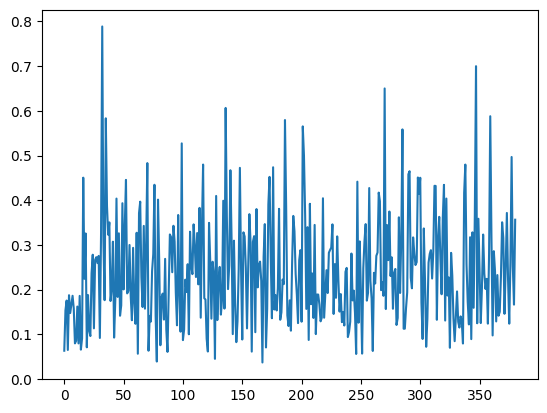

In [15]:
import matplotlib.pyplot as plt

plt.plot(distances);

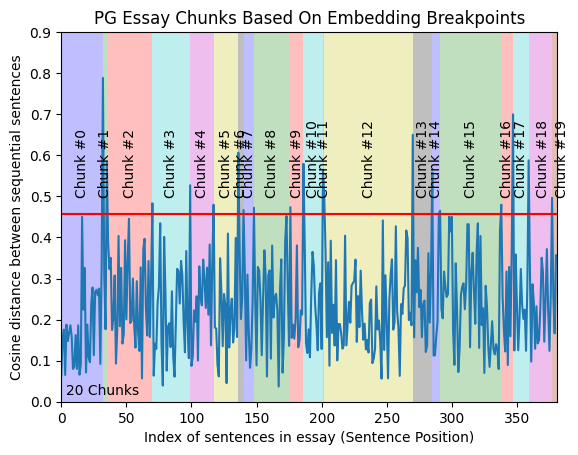

In [20]:
import numpy as np

plt.plot(distances);

y_upper_bound = .9
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
            y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
            s=f"Chunk #{i}", horizontalalignment='center',
            rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                s=f"Chunk #{i+1}",
                rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

Well now that we've succefully distracted ourselves with a visualization, now we need to combine the sentences into chunks.

Because we have our breakpoints [23, 40, 51...] I want to make the first chunk 0-22, since the distance jumped on sentence 23.

In [21]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [22]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
October 2006

(This essay is derived from a talk at MIT.)

Till recently graduating seniors had two choices: get a job or go to grad school. I think there will increasingly be a third option: to start
...
m into a rush of activity. Even if you start a startup explicitly to get rich, the money you might get seems pretty theoretical most of the time. What drives you day to day is not wanting to look bad.


Chunk #1
You probably can't change that. Even if you could, I don't think you'd want to; someone who really, truly doesn't care what his peers think of him is probably a psychopath. So the best you can do is c
...
you'd want to; someone who really, truly doesn't care what his peers think of him is probably a psychopath. So the best you can do is consider this force like a wind, and set up your boat accordingly.




I want to re-emphasize that this is an exploration of a method that is far from usable yet. This method should be tested with RAG eval to ensure that it works for your use case.

I didn't worry about chunk size or overlap with this method, but you could recursively split large chunks if you needed to.

How should it be improved? Let me know! See me tease this here.

### Level 5: Agentic Chunking

Tomando el nivel 4 un poco mas allá, podemos darle la misma instrucción a un LLM para que lo haga como lo haría un humano?

Pero, como es que un humano haría un chunking?. Basados en el nivel 4 podríamos seguir los siguientes pasos:

1. Tomamos una hoja de papel
2. Comenzariamos con la primera frase y asumimos que será el primer chunk, dado que no tenemos ningún otro.
3. Seguimos leyendo el documento y evaluando si es un nuevo chunk o es parte del chunk anterior o alguno existente. Si es similar a uno existente, lo concatenamos a ese chunk, si no, creamos uno nuevo.
4. Seguimos haciendo esto hasta que terminamos el documento.

In [24]:
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_community.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain.chains import create_extraction_chain
from typing import Optional, List
from langchain.chains import create_extraction_chain_pydantic
from langchain_core.pydantic_v1 import BaseModel
from langchain import hub

In [25]:
obj = hub.pull("wfh/proposal-indexing")
llm = ChatOpenAI(model='gpt-4-1106-preview', openai_api_key = os.getenv("OPENAI_API_KEY", 'YouKey'))

LangSmithUserError: API key must be provided when using hosted LangSmith API